# Improved LSTM

### Reading and Analyzing the data

In [301]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Extracting the toxic data for visualization

Text(0.5, 0, 'category')

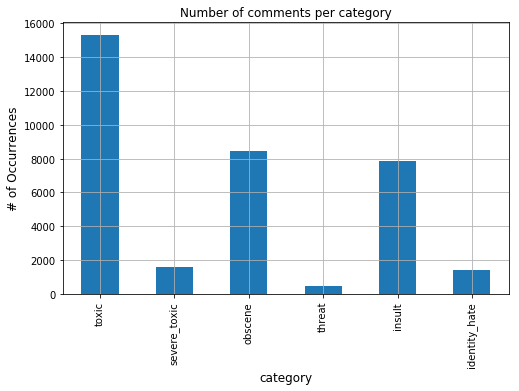

In [302]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
test_ground_truth = pd.read_csv("test_labels.csv")

train_toxic = train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
toxic_count = train_toxic.sum().to_frame()
toxic_count['category'] = list(toxic_count.index)
toxic_count['number_of_comments'] = toxic_count[0]
toxic_count = toxic_count.drop(columns=[0]).reset_index()
toxic_count = toxic_count.drop(columns=['index'])

toxic_count.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

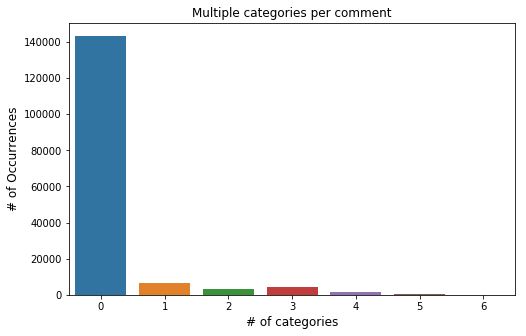

In [303]:
import seaborn as sns
rowsums = train_data.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

# Start of work

- Stopwords
- Stem
- Translation
- Spell correction
- Punctuation. Twitter style character preprocessing Keeping "!", "?" (but adding spaces between them) and single quotes.
- Spam

Reference
- [Best single model](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644)
- [1st place (Alex's model)](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52557)
- [Detailed instructions](https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda)
- [Sample code based on Alex's model](https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model)

### Data Processing

In [304]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    # Convert to string
    comment=str(comment)
    #Convert to lower case , so that Hi and hi are the same
#     comment=comment.lower()
    #remove \n
    comment=re.sub("\\n"," ",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    # https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644
    special_character_removal=re.compile(r'[^a-z\?\!\.\,\' ]',re.IGNORECASE)
    comment=special_character_removal.sub(" ", comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[appos[word] if word in appos else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
#     words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    clean_sent=re.sub("\'", "", clean_sent)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [305]:
import re
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
from nltk.stem.wordnet import WordNetLemmatizer 
from appos import appos
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# Load input data
EN = pd.read_csv("train.csv")
FR = pd.read_csv("train_fr.csv")
ES = pd.read_csv("train_es.csv")
DE = pd.read_csv("train_de.csv")



train_data = pd.concat([EN, FR, ES, DE])

test_data = pd.read_csv("test.csv")
test_ground_truth = pd.read_csv("test_labels.csv")


# Prepare settings
eng_stopwords = set(stopwords.words("english"))

# Prepare input data
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 
              'insult', 'identity_hate']
train_data['none'] = 1-train_data[label_cols].max(axis=1)

train_data['comment_text'].fillna("something", inplace=True)
test_data['comment_text'].fillna("something", inplace=True)


# Initiate
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

### Split into train and test 

In [306]:
from sklearn.model_selection import train_test_split

## For getting the predicted variable
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


train = train_data
test = test_data


In [309]:
%%time
# This is time-consuming. Set the boolean check if necessary
if 1==1:
    corpus_train = [clean(text) for text in train['comment_text']]
    corpus_test = [clean(text) for text in test['comment_text']]
    
    # Write clean corpus to local
    with open('clean_unigram_comment_train_with_stopword.txt', 'w', encoding='utf-8') as f:
        for comment in corpus_train:
            f.write(comment + '\n')

    with open('clean_unigram_comment_test_with_stopword.txt', 'w', encoding='utf-8') as f:
        for comment in corpus_test:
            f.write(comment + '\n')  

CPU times: user 5min 31s, sys: 2.29 s, total: 5min 33s
Wall time: 5min 36s


In [310]:
# Read processed corpus from local
with open('clean_unigram_comment_train_with_stopword.txt', 'r') as f:
    corpus_train = f.readlines()
    
with open('clean_unigram_comment_test_with_stopword.txt', 'r') as f:
    corpus_test = f.readlines()    

### Spamming

In [311]:
train['count_unique_word']=train["comment_text"].apply(lambda x: len(set(str(x).split())))
train['count_word']=train["comment_text"].apply(lambda x: len(str(x).split()))
train['word_unique_percent']=train['count_unique_word']*100/train['count_word']
spammers=train[train['word_unique_percent']<30]

In [312]:
spammers.comment_text.to_csv('spammer.txt')

## Helper Functions

In [313]:
# Remove negative test cases
def get_classification_report(y_test, preds):
    new_y_test = y_test[y_test['toxic'] != -1]
    new_preds = preds[y_test['toxic'] != -1]
#     new_pred_prob = predict[y_test['toxic'] != -1]
    print(classification_report(new_y_test, new_preds))

In [314]:
def sample_false_negative(df, labels, label, preds, preds_prob, write=False, n=20):
    for i, category in enumerate(labels):
        df[category+'_prob'] = preds_prob[:,i]
        df[category+'_pred'] = preds[:,i]
    df['len_comment'] = df['comment_text'].apply(lambda x: len(x.split(' ')))
    
    if write:
        for i, category in enumerate(labels):
            print("... working on {}".format(category))
            df[['comment_text', category, category+'_prob', category+'_pred', 'len_comment']].iloc[\
                np.argwhere(preds[:,i] == 0).flatten().tolist()][df[category]==1].to_csv(
                category+'_false_negative.csv')

    return df[['comment_text', label, label+'_prob', label+'_pred', 'len_comment']].iloc[
        np.argwhere(preds[:,0] == 0).flatten().tolist()][df['toxic']==1][:n]

In [315]:
# WIP
def top_feats(tfidf, log_mod, n):
    top_n_index = np.argpartition(log_mod.coef_[0], -n)[-n:]
    feature_array = np.array(tfidf.get_feature_names())
    return zip(top_n_index, feature_array[top_n_index], log_mod.coef_[0][top_n_index])

## LSTM

In [230]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [231]:
# Input:
# corpus_train
# corpus_test
# train
# test

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(corpus_train)
list_tokenized_train = tokenizer.texts_to_sequences(corpus_train)
list_tokenized_test = tokenizer.texts_to_sequences(corpus_test)

maxlen = 200
x_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
x_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
y_train = train[label_cols].values
y_test = test_ground_truth[label_cols]

totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [232]:
def get_model():
    inp = Input(shape=(maxlen, ))
    embed_size = 128
    x = Embedding(max_features, embed_size)(inp)
    x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [233]:
%%time
model = get_model()
batch_size = 32
epochs = 2


file_path="weights_base.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

callbacks_list = [checkpoint, early] #early
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

# y_test = model.predict(X_te)

Train on 172771 samples, validate on 19197 samples
Epoch 1/2
172771/172771 [==============================] - 855s 5ms/step - loss: 0.0964 - acc: 0.9656 - val_loss: 0.3953 - val_acc: 0.8473

Epoch 00001: val_loss improved from inf to 0.39527, saving model to weights_base.best.hdf5
Epoch 2/2
172771/172771 [==============================] - 856s 5ms/step - loss: 0.0680 - acc: 0.9734 - val_loss: 0.3222 - val_acc: 0.8675

Epoch 00002: val_loss improved from 0.39527 to 0.32224, saving model to weights_base.best.hdf5
CPU times: user 1h 22min 52s, sys: 26min 9s, total: 1h 49min 1s
Wall time: 28min 33s


In [234]:
%%time
preds_prob = model.predict([x_test], batch_size=1024, verbose=1)
preds = np.zeros((len(test), len(label_cols)))
for i, category in enumerate(label_cols):
    preds[:,i] = [1 if x >= 0.5 else 0 for x in preds_prob[:,i]]

153164/153164 [==============================] - 67s 434us/step
CPU times: user 2min 51s, sys: 1min 19s, total: 4min 10s
Wall time: 1min 8s


In [235]:
# Remove negative test cases
get_classification_report(y_test, preds) 

              precision    recall  f1-score   support

           0       0.51      0.88      0.65      6090
           1       0.44      0.40      0.42       367
           2       0.59      0.79      0.67      3691
           3       0.00      0.00      0.00       211
           4       0.63      0.66      0.64      3427
           5       0.67      0.00      0.01       712

   micro avg       0.55      0.74      0.63     14498
   macro avg       0.47      0.45      0.40     14498
weighted avg       0.56      0.74      0.61     14498
 samples avg       0.08      0.07      0.07     14498



In [240]:
test[label_cols] = y_test
sample_false_negative(test, label_cols, 'severe_toxic', preds, preds_prob, write=True)

... working on toxic
... working on severe_toxic
... working on obscene
... working on threat
... working on insult
... working on identity_hate


,comment_text,severe_toxic,severe_toxic_prob,severe_toxic_pred,len_comment
21,"Arabs be commit genocide in Iraq , but no prot...",0,0.000625,0.0,20
76,How dare you vandalize that page about the HMS...,0,0.000642,0.0,17
219,"Eek , but shes cute in an earthy kind of way ....",0,0.000239,0.0,26
333,"So , on the tenth anniversary of , New York Ti...",0,0.000376,0.0,262
664,Karl Tearle be a mop haired twat\n,0,0.002196,0.0,7
1124,Intolerance in India india be a Generator of l...,0,0.000954,0.0,11
1255,Because the overall aim of the project be wort...,0,0.000305,0.0,85
1758,And cybersex . .\n,0,0.001470,0.0,6
1863,I remove the frogs penis caption . The real na...,0,0.000198,0.0,46
2003,"someone , please edit this line The Lebanon Op...",0,0.000083,0.0,33


## Improved LSTM Model

In [316]:
import numpy as np
np.random.seed(42)
import pandas as pd
import string
import re

import gensim
from collections import Counter
import pickle

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, LSTM,Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.preprocessing import text, sequence

from keras.callbacks import Callback
from keras import optimizers
from keras.layers import Lambda

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords

import os
os.environ['OMP_NUM_THREADS'] = '4'

import gc
from keras import backend as K
from sklearn.model_selection import KFold

from unidecode import unidecode

import time

eng_stopwords = set(stopwords.words("english"))



In [318]:
# Input:

def add_features(df):
    
    df['comment_text'] = df['comment_text'].apply(lambda x:str(x))
    df['total_length'] = df['comment_text'].apply(len)
    df['capitals'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']+0.1),
                                axis=1)
    df['num_words'] = df.comment_text.str.count('\S+')
    df['num_unique_words'] = df['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']  

    return df

train = train_data
test = test_data

train['comment_text'] = corpus_train
test['comment_text'] = corpus_test

train = add_features(train)
test = add_features(test)

features = train[['caps_vs_length', 'words_vs_unique']].fillna(0)
test_features = test[['caps_vs_length', 'words_vs_unique']].fillna(0)

ss = StandardScaler()
ss.fit(np.vstack((features, test_features)))
features = ss.transform(features)
test_features = ss.transform(test_features)

y_train = train[label_cols].values
y_test = test_ground_truth[label_cols]

In [319]:
# For best score (Public: 9869, Private: 9865), change to max_features = 283759, maxlen = 900
max_features = 20000
maxlen = 100

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(corpus_train) + list(corpus_test))
X_train_sequence = tokenizer.texts_to_sequences(corpus_train)
X_test_sequence = tokenizer.texts_to_sequences(corpus_test)

x_train = sequence.pad_sequences(X_train_sequence, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test_sequence, maxlen=maxlen)
print(len(tokenizer.word_index))

y_train = train[label_cols].values
y_test = test_ground_truth[label_cols]

316576


In [320]:
%%time
# Load the FastText Web Crawl vectors
EMBEDDING_FILE_FASTTEXT="/Users/Zhenfeng/Downloads/crawl-300d-2M.vec"
EMBEDDING_FILE_TWITTER="/Users/Zhenfeng/Downloads/glove/glove.twitter.27B.200d.txt"
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

CPU times: user 11 µs, sys: 18 µs, total: 29 µs
Wall time: 33.9 µs


In [321]:
embeddings_index_ft = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE_FASTTEXT,encoding='utf-8'))
embeddings_index_tw = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE_TWITTER,encoding='utf-8'))

In [322]:
%%time
spell_model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE_FASTTEXT)

CPU times: user 8min 2s, sys: 17.2 s, total: 8min 19s
Wall time: 8min 32s


In [323]:
words = spell_model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank

# Use fast text as vocabulary
def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def singlify(word):
    return "".join([letter for i,letter in enumerate(word) if i == 0 or letter != word[i-1]])

In [324]:
%%time
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words,501))

something_tw = embeddings_index_tw.get("something")
something_ft = embeddings_index_ft.get("something")

something = np.zeros((501,))
something[:300,] = something_ft
something[300:500,] = something_tw
something[500,] = 0

def all_caps(word):
    return len(word) > 1 and word.isupper()

def embed_word(embedding_matrix,i,word):
    embedding_vector_ft = embeddings_index_ft.get(word)
    if embedding_vector_ft is not None: 
        if all_caps(word):
            last_value = np.array([1])
        else:
            last_value = np.array([0])
        embedding_matrix[i,:300] = embedding_vector_ft
        embedding_matrix[i,500] = last_value
        embedding_vector_tw = embeddings_index_tw.get(word)
        if embedding_vector_tw is not None:
            embedding_matrix[i,300:500] = embedding_vector_tw

            
# Fasttext vector is used by itself if there is no glove vector but not the other way around.
for word, i in word_index.items():
    
    if i >= max_features: continue
        
    if embeddings_index_ft.get(word) is not None:
        embed_word(embedding_matrix,i,word)
    else:
        # change to > 20 for better score. Previously 0
        if len(word) > 20:
            embedding_matrix[i] = something
        else:
            word2 = correction(word)
            if embeddings_index_ft.get(word2) is not None:
                embed_word(embedding_matrix,i,word2)
            else:
                word2 = correction(singlify(word))
                if embeddings_index_ft.get(word2) is not None:
                    embed_word(embedding_matrix,i,word2)
                else:
                    embedding_matrix[i] = something 

CPU times: user 2min 6s, sys: 2.94 s, total: 2min 9s
Wall time: 2min 14s


In [325]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.max_score = 0
        self.not_better_count = 0

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
                model.save_weights("weights_alex.best.hdf5")
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 3:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

In [170]:
sample_false_negative(test, label_cols, 'toxic', preds, pred_prob, write=True)

... working on toxic
... working on severe_toxic
... working on obscene
... working on threat
... working on insult
... working on identity_hate


,comment_text,toxic,toxic_prob,toxic_pred,len_comment
116638,Bullshit! \n\nThe section used to be a neat li...,1,0.070182,0.0,108
132808,"""\n\nUk55\nI fess-up, you have caught me again...",1,0.102789,0.0,25
89694,You \nDonny Osmond is an arsehole! Let me post...,1,0.115277,0.0,15
50963,Vandalism \n\nStop vandalising pages. You are ...,1,0.119278,0.0,8
25594,Elonka \nSucks black cocks.,1,0.119911,0.0,4
30136,Please refrain from unmaking unconstructive ed...,1,0.082884,0.0,52
119339,"""\n \n\nYour request to be unblocked has been...",1,0.092669,0.0,21
87562,Stop with the garbage \nI'll say irrelevant as...,1,0.085786,0.0,22
105726,Thanks. Also thanks for freezing the article. ...,1,0.115219,0.0,14
114979,The Cut-Away Diagram is Shit \n\nI hold two ba...,1,0.083338,0.0,50


In [326]:
def get_model(features,clipvalue=1.,num_filters=40,dropout=0.5,embed_size=501):
    features_input = Input(shape=(features.shape[1],))
    inp = Input(shape=(maxlen, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)

    x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=[inp,features_input], outputs=x)
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model    

In [327]:
# %%time
model = get_model(features)

batch_size = 32


epochs = 5
gc.collect()
K.clear_session()


num_folds = 2 

predict = np.zeros((test.shape[0],6))

kf = KFold(n_splits=num_folds, shuffle=True, random_state=239)

for train_index, test_index in kf.split(x_train):
    
    kfold_y_train,kfold_y_test = y_train[train_index], y_train[test_index]
    kfold_X_train = x_train[train_index]
    kfold_X_features = features[train_index]
    kfold_X_valid = x_train[test_index]
    kfold_X_valid_features = features[test_index] 
    
    gc.collect()
    K.clear_session()
    
    model = get_model(features)
    
    ra_val = RocAucEvaluation(validation_data=([kfold_X_valid,kfold_X_valid_features], kfold_y_test), interval = 1)
    
    model.fit([kfold_X_train,kfold_X_features], kfold_y_train, batch_size=batch_size, epochs=epochs, verbose=1,
             callbacks = [ra_val])
    gc.collect()
    
    predict += model.predict([x_test,test_features], batch_size=batch_size,verbose=1) / num_folds

print("Done")   

Epoch 1/5
319142/319142 [==============================] - 161s 506us/step

 ROC-AUC - epoch: 1 - score: 0.984031 

*** New High Score (previous: 0.000000) 

Epoch 2/5
319142/319142 [==============================] - 167s 523us/step

 ROC-AUC - epoch: 2 - score: 0.985360 

*** New High Score (previous: 0.984031) 

Epoch 3/5
319142/319142 [==============================] - 167s 522us/step

 ROC-AUC - epoch: 3 - score: 0.986331 

*** New High Score (previous: 0.985360) 

Epoch 4/5
319142/319142 [==============================] - 170s 531us/step

 ROC-AUC - epoch: 4 - score: 0.987210 

*** New High Score (previous: 0.986331) 

Epoch 5/5
319142/319142 [==============================] - 164s 515us/step

 ROC-AUC - epoch: 5 - score: 0.987618 

*** New High Score (previous: 0.987210) 

153164/153164 [==============================] - 79s 517us/step
Epoch 1/5
319142/319142 [==============================] - 163s 511us/step

 ROC-AUC - epoch: 1 - score: 0.983837 

*** New High Score (previous: 

In [342]:
# Query to load model
model = get_model(features)
model.load_weights("weights_alex.best.hdf5")

In [343]:
test[label_cols] = y_test
pred_prob = model.predict([x_test,test_features], batch_size=32,verbose=1)
preds = np.zeros((len(test), len(label_cols)))
for i, category in enumerate(label_cols):
    preds[:,i] = [1 if x >= 0.5 else 0 for x in pred_prob[:,i]]

153164/153164 [==============================] - 80s 524us/step


In [344]:
get_classification_report(y_test, preds)

              precision    recall  f1-score   support

           0       0.53      0.86      0.66      6090
           1       0.35      0.53      0.42       367
           2       0.60      0.79      0.68      3691
           3       0.45      0.45      0.45       211
           4       0.62      0.70      0.66      3427
           5       0.67      0.51      0.58       712

   micro avg       0.56      0.77      0.65     14498
   macro avg       0.54      0.64      0.57     14498
weighted avg       0.57      0.77      0.65     14498
 samples avg       0.07      0.07      0.07     14498



In [345]:
def get_accuracy(y_test, preds):
    new_y_test = y_test[y_test['toxic'] != -1]
    new_preds = preds[y_test['toxic'] != -1]
    accuracies = []
    for i, category in enumerate(label_cols):
        accuracies.append(accuracy_score(
                new_y_test[category], new_preds[:,i]))
        print('Test accuracy is {}'.format(accuracy_score(
                new_y_test[category], new_preds[:,i])))
    #     new_pred_prob = predict[y_test['toxic'] != -1]
    print("Mean Accuracy is {}".format(np.mean(accuracies)))

In [346]:
get_accuracy(y_test, preds)

Test accuracy is 0.9151270749320078
Test accuracy is 0.9915127074932008
Test accuracy is 0.9570633655319016
Test accuracy is 0.9964050142236394
Test accuracy is 0.9610647410047204
Test accuracy is 0.9917471630873113
Mean Accuracy is 0.9688200110454636
